<a href="https://colab.research.google.com/github/HammadAhmadMian/Final-Project/blob/main/Prediction_of_Gold_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch pyro-ppl
!pip install yfinance
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.2 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import mplfinance as mpf
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

In [3]:
ticker = "GC=F"

data = yf.download(ticker, start="2010-01-01", end="2024-12-31")

data.to_csv("Gold_historical_data.csv")

/tmp/ipython-input-844112362.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.read_csv('Gold_historical_data.csv')
df

,Price,Close,High,Low,Open,Volume
0,Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
1,Date,NaN,NaN,NaN,NaN,NaN
2,2010-01-04,1117.699951171875,1122.300048828125,1097.0999755859375,1117.699951171875,184
3,2010-01-05,1118.0999755859375,1126.5,1115.0,1118.0999755859375,53
4,2010-01-06,1135.9000244140625,1139.199951171875,1120.699951171875,1135.9000244140625,363
...,...,...,...,...,...,...
3767,2024-12-23,2612.300048828125,2627.699951171875,2611.10009765625,2620.0,451
3768,2024-12-24,2620.0,2620.0,2609.5,2613.0,35
3769,2024-12-26,2638.800048828125,2638.800048828125,2627.89990234375,2628.5,84
3770,2024-12-27,2617.199951171875,2617.699951171875,2616.39990234375,2617.699951171875,642


In [5]:
df = df.iloc[2:].copy()
df.rename(columns={'Price': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3770 entries, 2 to 3771
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3770 non-null   datetime64[ns]
 1   Close   3770 non-null   object        
 2   High    3770 non-null   object        
 3   Low     3770 non-null   object        
 4   Open    3770 non-null   object        
 5   Volume  3770 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 176.8+ KB


In [7]:
for col in df.columns:
  if col != 'Date':
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3770 entries, 2 to 3771
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3770 non-null   datetime64[ns]
 1   Close   3770 non-null   float64       
 2   High    3770 non-null   float64       
 3   Low     3770 non-null   float64       
 4   Open    3770 non-null   float64       
 5   Volume  3770 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 176.8 KB


In [8]:
ticker = "DX-Y.NYB"
data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
data.to_csv("DXY_historical_data.csv")
df_dxy = pd.read_csv('DXY_historical_data.csv')
df_dxy = df_dxy.iloc[2:].copy()
df_dxy.rename(columns={'Price': 'Date'}, inplace=True)
df_dxy.rename(columns={'Close': 'DXY'}, inplace=True)
df_dxy['Date'] = pd.to_datetime(df_dxy['Date'])
df_dxy

/tmp/ipython-input-496288660.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


,Date,DXY,High,Low,Open,Volume
2,2010-01-04,77.52999877929688,78.19000244140625,77.26000213623047,77.93000030517578,0
3,2010-01-05,77.62000274658203,77.70999908447266,77.08999633789062,77.37000274658203,0
4,2010-01-06,77.48999786376953,78.0,77.36000061035156,77.6500015258789,0
5,2010-01-07,77.91000366210938,78.08000183105469,77.30000305175781,77.37000274658203,0
6,2010-01-08,77.47000122070312,78.19000244140625,77.3499984741211,77.9800033569336,0
...,...,...,...,...,...,...
3769,2024-12-23,108.04000091552734,108.27999877929688,107.68000030517578,107.81999969482422,0
3770,2024-12-24,108.26000213623047,108.30000305175781,107.91999816894531,108.16000366210938,0
3771,2024-12-26,108.12999725341797,108.30000305175781,108.02999877929688,108.16999816894531,0
3772,2024-12-27,108.0,108.19999694824219,107.87000274658203,108.08000183105469,0


In [9]:
df = pd.concat([df, df_dxy['DXY']], axis=1)
df

,Date,Close,High,Low,Open,Volume,DXY
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184.0,77.52999877929688
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53.0,77.62000274658203
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363.0,77.48999786376953
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56.0,77.91000366210938
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54.0,77.47000122070312
...,...,...,...,...,...,...,...
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84.0,108.04000091552734
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642.0,108.26000213623047
3771,2024-12-30,2606.100098,2626.899902,2597.000000,2620.699951,794.0,108.12999725341797
3772,NaT,NaN,NaN,NaN,NaN,NaN,108.0


In [10]:
df[['Close','High','Low','Open','Volume']].describe()

,Close,High,Low,Open,Volume
count,3770.000000,3770.000000,3770.000000,3770.000000,3770.000000
mean,1544.688089,1552.404033,1536.741379,1544.753634,5326.996021
std,350.965404,352.763846,349.150017,350.844368,28706.855400
min,1050.800049,1062.000000,1045.199951,1052.199951,0.000000
25%,1260.699951,1267.199951,1254.325043,1260.049988,45.000000
50%,1435.800049,1445.099976,1430.350037,1436.849976,158.000000
75%,1784.700012,1794.049988,1776.950012,1786.250031,517.250000
max,2788.500000,2789.000000,2774.600098,2787.399902,386334.000000


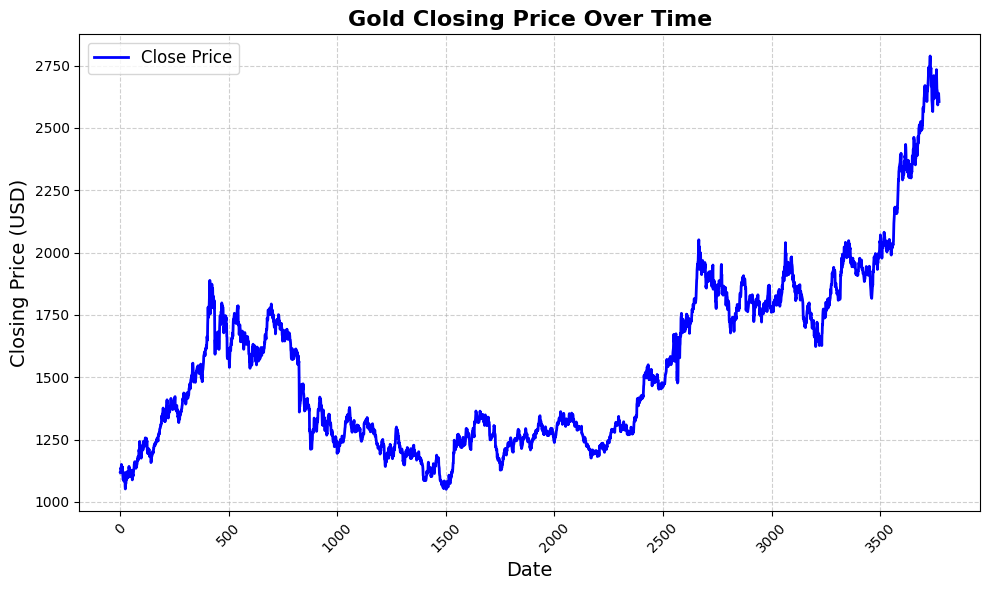

In [11]:
plt.figure(figsize=(10,6))
plt.plot(df['Close'], color='blue', linewidth=2, label='Close Price')

plt.title('Gold Closing Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

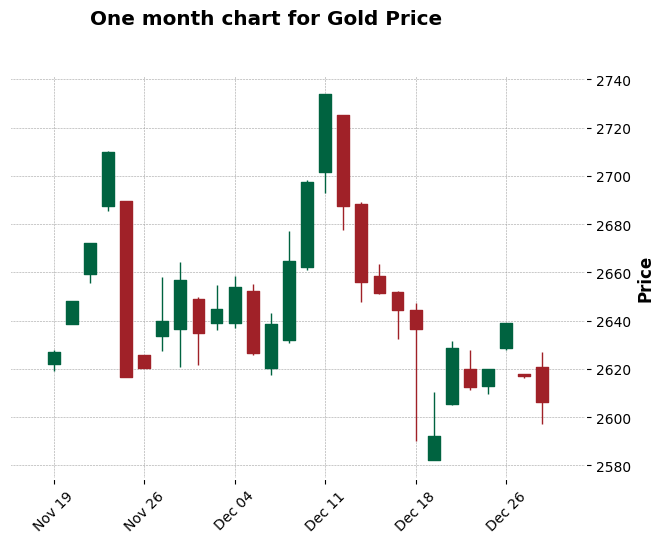

In [12]:
df_year = df.iloc[-30:].copy()
df_year['Date'] = pd.to_datetime(df_year['Date'])
df_year.set_index('Date', inplace=True)
df_year.dropna(inplace=True)
mpf.plot(df_year, type='candle', style='charles', title='One month chart for Gold Price')